In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Đọc dữ liệu


In [ ]:
data = pd.read_csv("heart.csv")  # Load từ file CSV (bạn thay thế bằng pandas nếu muốn)

X = data.drop(columns=["target"]).values
y = data["target"].values

# AdaBoost yêu cầu nhãn phải là -1 hoặc 1
y = np.where(y == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
X_train.shape, X_test.shape

((922, 13), (103, 13))

### Xây dựng mô hình


### 1. Tạo weak classifier (dùng Decision stump)


In [ ]:
def weak_classifier(X, feature_index, threshold, polarity):
    predictions = np.ones(X.shape[0])
    if polarity == 1:
        predictions[X[:, feature_index] < threshold] = -1
    else:
        predictions[X[:, feature_index] > threshold] = -1
    return predictions

### 2. Cập nhật trọng số cho mỗi mẫu dữ liệu

In [ ]:
def train_adaboost(X, y, n_estimators=10):
    n_samples, n_features = X.shape
    weights = np.ones(n_samples) / n_samples
    classifiers = []

    for _ in range(n_estimators):
        best_feature, best_threshold, best_polarity, min_error = (
            None,
            None,
            None,
            float("inf"),
        )
        best_predictions = None

        for feature_index in range(n_features):
            # Xoá các giá trị trùng lặp, ví dụ np.unique([1, 1, 2, 2, 3, 3]) = [1, 2, 3]
            unique_values  = np.unique(X[:, feature_index])
            thresholds = (unique_values[:-1] + unique_values[1:]) / 2

            for threshold in thresholds:
                for polarity in [1, -1]:
                    predictions = weak_classifier(X, feature_index, threshold, polarity)
                    error = sum(weights[predictions != y])

                    if error < min_error:
                        best_feature, best_threshold, best_polarity = (
                            feature_index,
                            threshold,
                            polarity,
                        )
                        min_error = error
                        best_predictions = predictions

        # Tránh lỗi chia cho 0
        if min_error == 0:
            min_error = 1e-10

        alpha = 0.5 * np.log((1 - min_error) / min_error)
        weights *= np.exp(-alpha * y * best_predictions)
        weights /= np.sum(weights)

        classifiers.append((alpha, best_feature, best_threshold, best_polarity))

    return classifiers

In [ ]:
def optimize_train_adaboost(X, y, n_estimators=10):
    n_samples, n_features = X.shape
    weights = np.ones(n_samples) / n_samples
    classifiers = []

    for _ in range(n_estimators):
        best_feature, best_threshold, best_polarity, min_error = None, None, None, float("inf")
        best_predictions = None

        for feature_index in range(n_features):
            unique_values = np.unique(X[:, feature_index])
            thresholds = np.linspace(unique_values.min(), unique_values.max(), num=10)  # Chỉ thử 10 threshold

            for threshold in thresholds:
                for polarity in [1, -1]:
                    predictions = weak_classifier(X, feature_index, threshold, polarity)
                    error = np.dot(weights, (predictions != y))  # Tối ưu tính toán error

                    if error < min_error:
                        best_feature, best_threshold, best_polarity = feature_index, threshold, polarity
                        min_error = error
                        best_predictions = predictions

        if min_error < 1e-3:  # Dừng sớm nếu error quá nhỏ
            break

        alpha = 0.5 * np.log((1 - min_error) / min_error)
        weights *= np.exp(-alpha * y * best_predictions)
        weights /= np.sum(weights)

        classifiers.append((alpha, best_feature, best_threshold, best_polarity))

    return classifiers

### 3. Predict

In [21]:
def predict_adaboost(X, classifiers):
    final_predictions = np.zeros(X.shape[0])
    for alpha, feature_index, threshold, polarity in classifiers:
        predictions = weak_classifier(X, feature_index, threshold, polarity)
        final_predictions += alpha * predictions
    return np.sign(final_predictions)

In [22]:
classifiers = train_adaboost(X_train, y_train, n_estimators=1000)

predictions = predict_adaboost(X_test, classifiers)
predictions = np.where(predictions == -1, 0, 1)

# Chuyển nhãn về {0,1} để tính accuracy
y_test_binary = np.where(y_test == -1, 0, 1)

accuracy = np.mean(predictions == y_test_binary)
print("Accuracy:", accuracy)

Accuracy: 0.941747572815534


### Vẽ đồ thị để chọn số lượng weak classifier (n_estimators) phù hợp


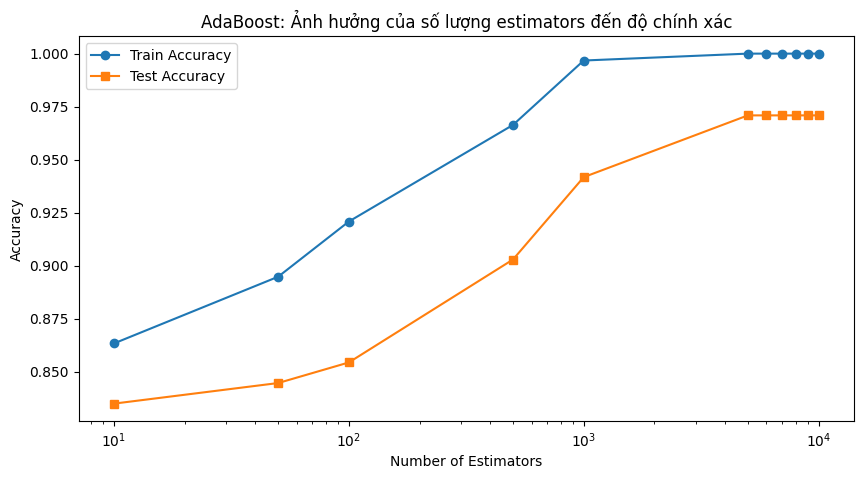

In [26]:
# Các giá trị n_estimators cần thử
n_range = [10, 50, 100, 500, 1000, 5000, 6000, 7000, 8000, 9000, 10000]
train_acc = []
test_acc = []

for n in n_range:
    classifiers = train_adaboost(X_train, y_train, n_estimators=n)

    train_predictions = predict_adaboost(X_train, classifiers)
    validation_predictions = predict_adaboost(X_test, classifiers)

    # Chuyển nhãn về {0,1} để tính accuracy
    train_predictions = np.where(train_predictions == -1, 0, 1)
    test_predictions = np.where(validation_predictions == -1, 0, 1)

    y_train_binary = np.where(y_train == -1, 0, 1)
    y_test_binary = np.where(y_test == -1, 0, 1)

    train_acc.append(np.mean(train_predictions == y_train_binary))
    test_acc.append(np.mean(test_predictions == y_test_binary))

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(n_range, train_acc, label="Train Accuracy", marker="o")
plt.plot(n_range, test_acc, label="Test Accuracy", marker="s")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.xscale("log")  # Dùng log-scale để dễ nhìn
plt.legend()
plt.title("AdaBoost: Ảnh hưởng của số lượng estimators đến độ chính xác")
plt.show()

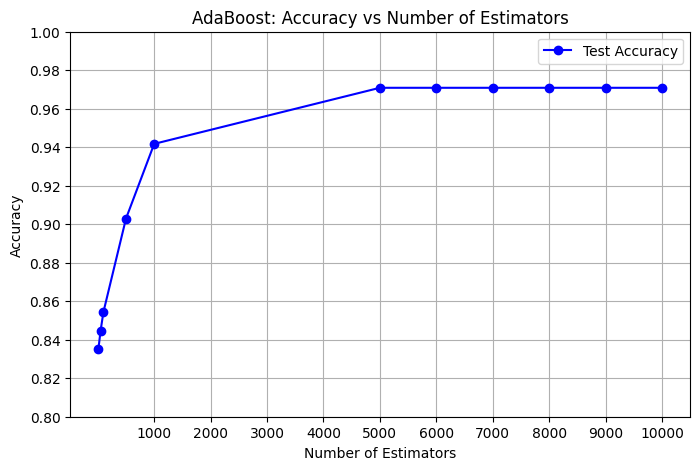

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử test_acc và n_range đã có sẵn
df = pd.DataFrame({"n_estimators": n_range, "test_accuracy": test_acc})

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(df["n_estimators"], df["test_accuracy"], marker="o", linestyle="-", color="b", label="Test Accuracy")

# Cố định trục X chỉ lấy bội số của 1000
plt.xticks(ticks=range(1000, max(n_range) + 1, 1000))

# Cố định trục Y hiển thị với bước nhảy cố định (vd: từ 0.8 đến 1.0, bước 0.02)
plt.yticks(ticks=[round(x, 2) for x in np.arange(0.8, 1.01, 0.02)])

plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("AdaBoost: Accuracy vs Number of Estimators")
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()